# Wasserstein GAN - WGAN
---

In [22]:
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint

In [23]:
from matplotlib import pyplot

In [24]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}

In [25]:
import tensorflow as tf

# Define the Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

In [26]:
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# weight constraint
	const = ClipConstraint(0.01)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, kernel_constraint=const))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# scoring, linear activation
	model.add(Flatten())
	model.add(Dense(1))
	# compile model
	opt = RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [27]:
define_critic().summary()

c:\Users\sulai\Documents\GH-Projects\GANs\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\sulai\Documents\GH-Projects\GANs\env\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 64)       │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         3,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,337 (274.75 KB)

 Trainable params: 70,081 (273.75 KB)

 Non-trainable params: 256 (1.00 KB)

In [28]:
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same', kernel_initializer=init))
	return model

In [29]:
# define_generator().summary()

In [30]:
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
	# make weights in the critic not trainable
	for layer in critic.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the critic
	model.add(critic)
	# compile model
	opt = RMSprop(learning_rate=0.00005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

In [31]:
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# select all of the examples for a given class
	selected_ix = trainy == 7
	X = trainX[selected_ix]
	# expand to 3d, e.g. add channels
	X = expand_dims(X, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

In [32]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels, -1 for 'real'
	y = -ones((n_samples, 1))
	return X, y
 

In [33]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [34]:
# Use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # directly call the generator
    X = generator(x_input, training=False)
    # create class labels with 1.0 for 'fake'
    y = tf.ones((n_samples, 1))
    return X, y

In [35]:
import os
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	filename1_dir = os.path.join('wgan_results', filename1)	
	pyplot.savefig(filename1_dir)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%04d.h5' % (step+1)
	filename2_dir = os.path.join('wgan_results', filename2)
	g_model.save(filename2_dir)
	print('>Saved: %s and %s' % (filename1, filename2_dir))

In [36]:
import os
result_path = os.path.join('wgan_results', 'plot_line_plot_loss.png')
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	# plot history
	pyplot.plot(d1_hist, label='crit_real')
	pyplot.plot(d2_hist, label='crit_fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend(result_path)
	pyplot.savefig()
	pyplot.close()

In [37]:
# Define the optimizers outside of the train_step function
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

@tf.function
def train_step(g_model, c_model, gan_model, real_images, latent_dim, n_batch, n_critic, critic_optimizer, generator_optimizer):
    c1_losses, c2_losses = [], []

    # Train the critic more frequently than the generator
    for _ in range(n_critic):
        # Generate fake images
        fake_images, y_fake = generate_fake_samples(g_model, latent_dim, n_batch // 2)
        y_real = -tf.ones((n_batch // 2, 1))  # Label for real images in WGAN

        # Update critic on real images
        with tf.GradientTape() as c_tape:
            real_output = c_model(real_images, training=True)
            fake_output = c_model(fake_images, training=True)
            c_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

        # Apply gradients to critic
        c_gradients = c_tape.gradient(c_loss, c_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(c_gradients, c_model.trainable_variables))
        c1_losses.append(c_loss)

    # Prepare latent points and inverted labels for generator update
    latent_points = generate_latent_points(latent_dim, n_batch)
    y_gan = -tf.ones((n_batch, 1))

    # Update generator via critic’s loss
    with tf.GradientTape() as g_tape:
        generated_images = g_model(latent_points, training=True)
        fake_output = c_model(generated_images, training=False)
        g_loss = -tf.reduce_mean(fake_output)

    # Apply gradients to generator
    g_gradients = g_tape.gradient(g_loss, g_model.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_gradients, g_model.trainable_variables))
    c2_losses.append(g_loss)

    return tf.reduce_mean(c1_losses), tf.reduce_mean(c2_losses), g_loss


In [38]:
# Train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    n_steps = bat_per_epo * n_epochs
    
    # Lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    
    for i in range(n_steps):
        # Get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, n_batch // 2)
        
        # Perform a training step
        c1_loss, c2_loss, g_loss = train_step(g_model, c_model, gan_model, X_real, latent_dim, n_batch, n_critic, critic_optimizer, generator_optimizer)
        
        # Track losses
        c1_hist.append(c1_loss)
        c2_hist.append(c2_loss)
        g_hist.append(g_loss)
        
        print(f'>{i+1}, c1={c1_loss:.3f}, c2={c2_loss:.3f}, g={g_loss:.3f}')
        
        # Summarize performance
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
    
    plot_history(c1_hist, c2_hist, g_hist)


c:\Users\sulai\Documents\GH-Projects\GANs\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(6265, 28, 28, 1)
>1, c1=0.735, c2=0.010, g=0.010
>2, c1=0.728, c2=-0.040, g=-0.040
>3, c1=0.913, c2=-0.081, g=-0.081
>4, c1=0.697, c2=-0.115, g=-0.115
>5, c1=0.982, c2=-0.146, g=-0.146
>6, c1=0.803, c2=-0.176, g=-0.176
>7, c1=1.023, c2=-0.211, g=-0.211
>8, c1=1.007, c2=-0.251, g=-0.251
>9, c1=1.033, c2=-0.297, g=-0.297
>10, c1=1.099, c2=-0.346, g=-0.346
>11, c1=1.288, c2=-0.399, g=-0.399
>12, c1=1.194, c2=-0.458, g=-0.458
>13, c1=1.159, c2=-0.530, g=-0.530
>14, c1=1.409, c2=-0.609, g=-0.609
>15, c1=1.648, c2=-0.689, g=-0.689
>16, c1=1.288, c2=-0.794, g=-0.794
>17, c1=1.400, c2=-0.913, g=-0.913
>18, c1=1.610, c2=-1.047, g=-1.047
>19, c1=1.536, c2=-1.187, g=-1.187
>20, c1=1.893, c2=-1.343, g=-1.343
>21, c1=1.727, c2=-1.492, g=-1.492
>22, c1=1.968, c2=-1.677, g=-1.677
>23, c1=1.781, c2=-1.871, g=-1.871
>24, c1=1.751, c2=-2.091, g=-2.091
>25, c1=1.936, c2=-2.340, g=-2.340
>26, c1=1.950, c2=-2.573, g=-2.573
>27, c1=1.984, c2=-2.852, g=-2.852
>28, c1=1.655, c2=-3.154, g=-3.154
>29, c1=2.190

AttributeError: module 'ntpath' has no attribute 'joint'

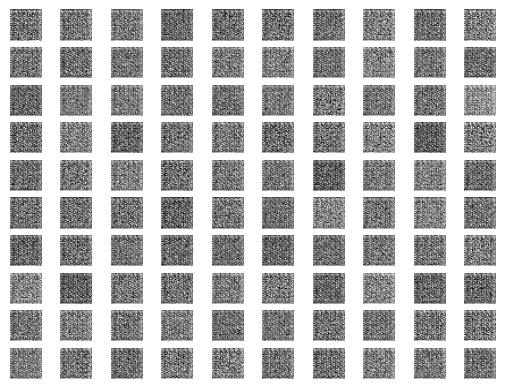

In [39]:
# size of the latent space
latent_dim = 50
# create the critic
critic = define_critic()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, critic)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, critic, gan_model, dataset, latent_dim)